# Machine Learning Evaluation of Differentially Expressed Genes
### Notebook 1 - Model and Gene Feature Evaluation

This notebook encompasses exploratory data analysis, data preparation, and machine learning model evaluations on gene expression data. The analysis includes visualizing train-test distribution based on random sampling, training models on bootstrapped data splits, evaluating performance metrics, and visualizing model coefficients and feature importances.

In [1]:
%reload_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore")

import os
import pickle as pkl
import pandas as pd
import numpy as np
import random
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from de_ml_functions import (
    prep_data,
    custom_train_test_split,
    train_models,
    train_models_boot_data,
    plot_model_scores,
    subplot_plot_model_scores,
    get_boot_splits
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

## Data Prep

Load dataframe of raw counts, donor_ids, and sample_ids

In [2]:
# Load data
ml_df, donor_ids, samples = prep_data()

## Data Exploration
Re-run this plot to see the distribution change.

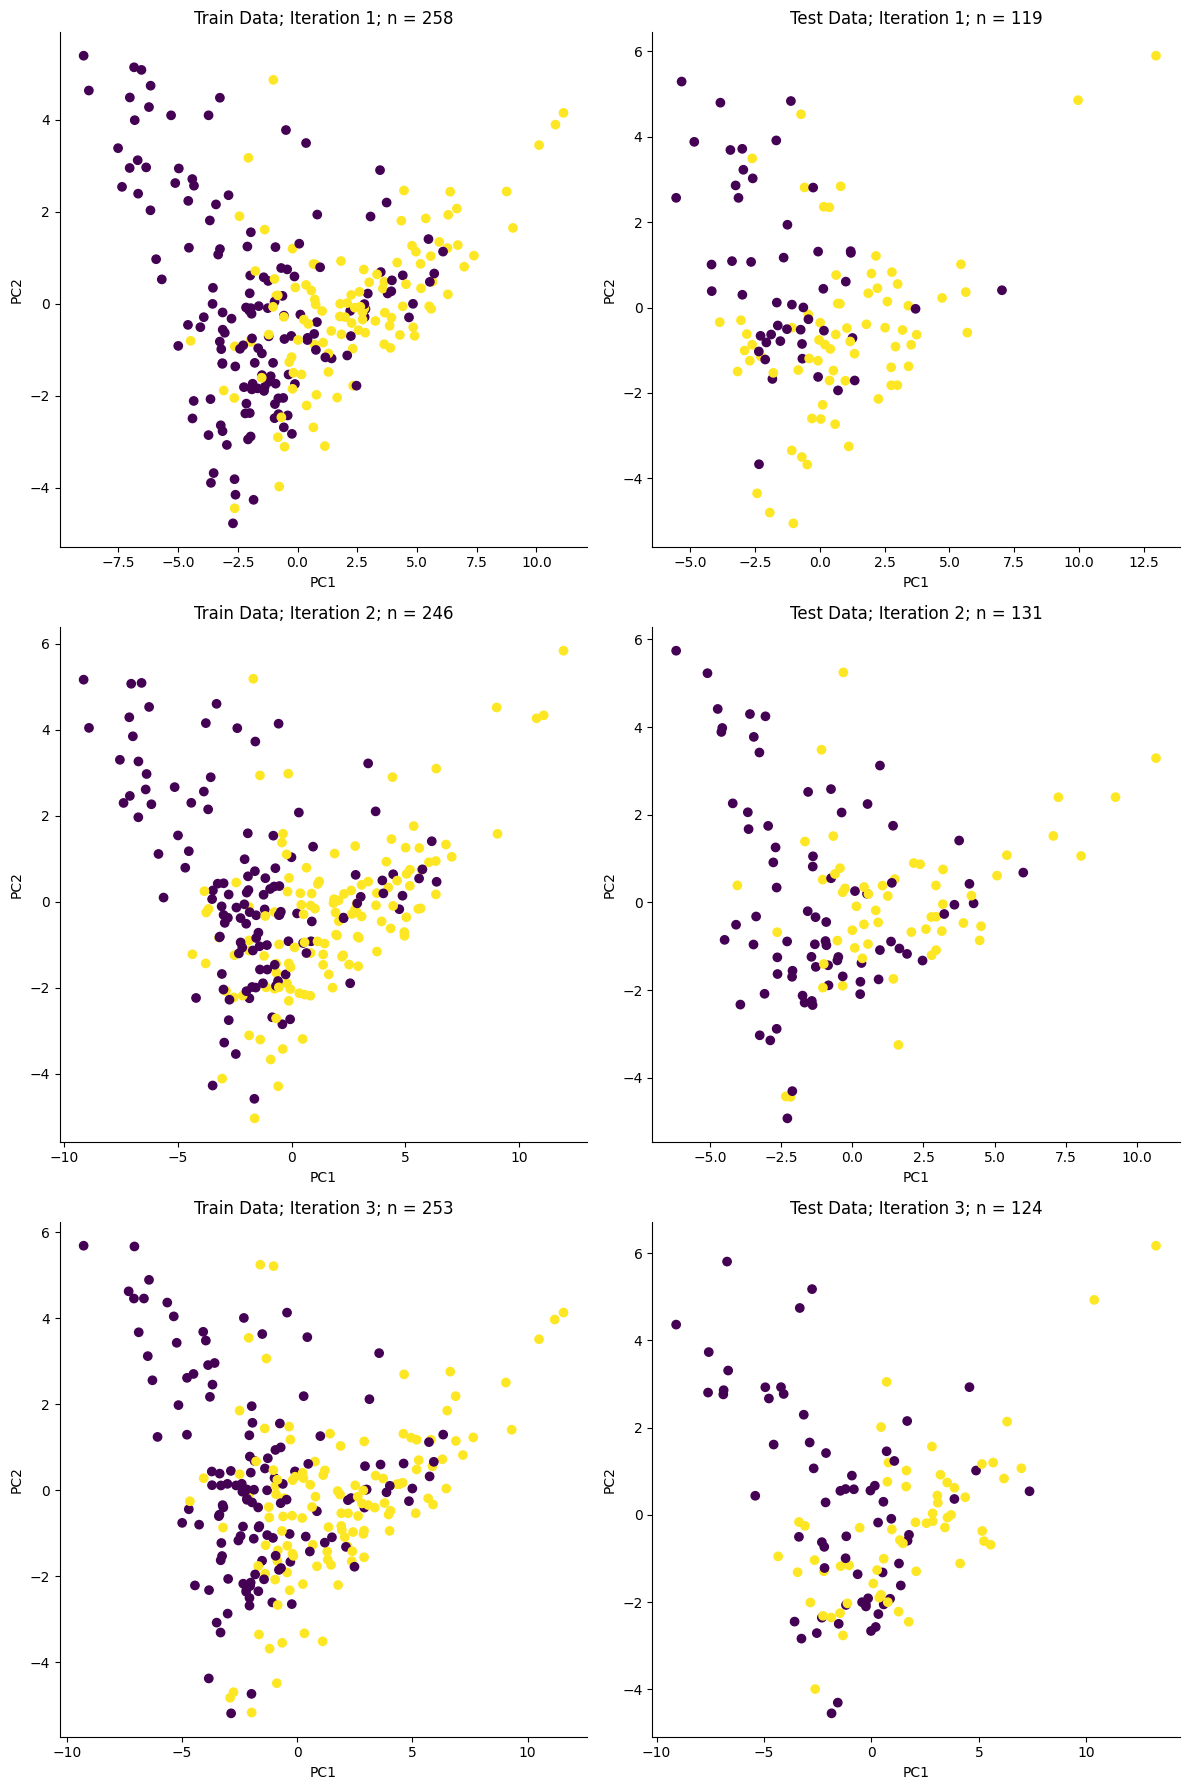

In [3]:
# Prep PCA
pca = PCA(n_components=2, random_state=42)

# Set the size of the plots and create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 18))  # 3 rows, 2 columns

for i in range(1, 4):
    X_train, y_train, X_test, y_test = custom_train_test_split(
        ml_df, donor_ids, samples
    )
    # Plot for Train Data
    X_train_pca = pca.fit_transform(X_train)
    axes[i - 1, 0].scatter(
        X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, label=y_train
    )
    axes[i - 1, 0].set_xlabel("PC1")
    axes[i - 1, 0].set_ylabel("PC2")
    axes[i - 1, 0].set_title(f"Train Data; Iteration {i}; n = {X_train.shape[0]}")
    axes[i - 1, 0].spines["top"].set_visible(False)
    axes[i - 1, 0].spines["right"].set_visible(False)
    # Plot for Test Data
    X_test_pca = pca.fit_transform(X_test)
    axes[i - 1, 1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, label=y_test)
    axes[i - 1, 1].set_xlabel("PC1")
    axes[i - 1, 1].set_ylabel("PC2")
    axes[i - 1, 1].set_title(f"Test Data; Iteration {i}; n = {X_test.shape[0]}")
    axes[i - 1, 1].spines["top"].set_visible(False)
    axes[i - 1, 1].spines["right"].set_visible(False)

# Adjust layout for better visualization
plt.tight_layout()


# Show the plots
plt.show()

## Train models on boostrapped data splits and evaluate performance

In [4]:
# Define models to test
models = [
    LogisticRegression(random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    SVC(kernel="linear", random_state=42),
    SVC(kernel="rbf", random_state=42),
    GaussianNB(),
    GradientBoostingClassifier(random_state=42),
    # DummyClassifier(strategy="most_frequent", random_state=42),
]

# List of model_names for output
model_names = [
    "Log_Reg",
    "DT",
    "RF",
    "SVM_linear",
    "SVM_radial",
    "GaussianNB",
    "Gradient_boosted",
    # "Dummy_most_freq",
]

In [5]:
file_path = "../data/processed/model_scores_dict.pkl"
# check if bootrapped_data already exists
if os.path.exists(file_path):
    # Load the data if the file exists
    with open(file_path, "rb") as file:
        model_scores_dict = pkl.load(file)
    print("Model Scores Loaded")

else:
    model_scores_dict = train_models_boot_data(
        ml_df, donor_ids, samples, models, model_names, iterations=1000
    )
    with open(file_path, "wb") as file:
        pkl.dump(model_scores_dict, file)


model_scores_dict.keys()

Model Scores Loaded


dict_keys(['Accuracy', 'Precision', 'Recall', 'F1'])

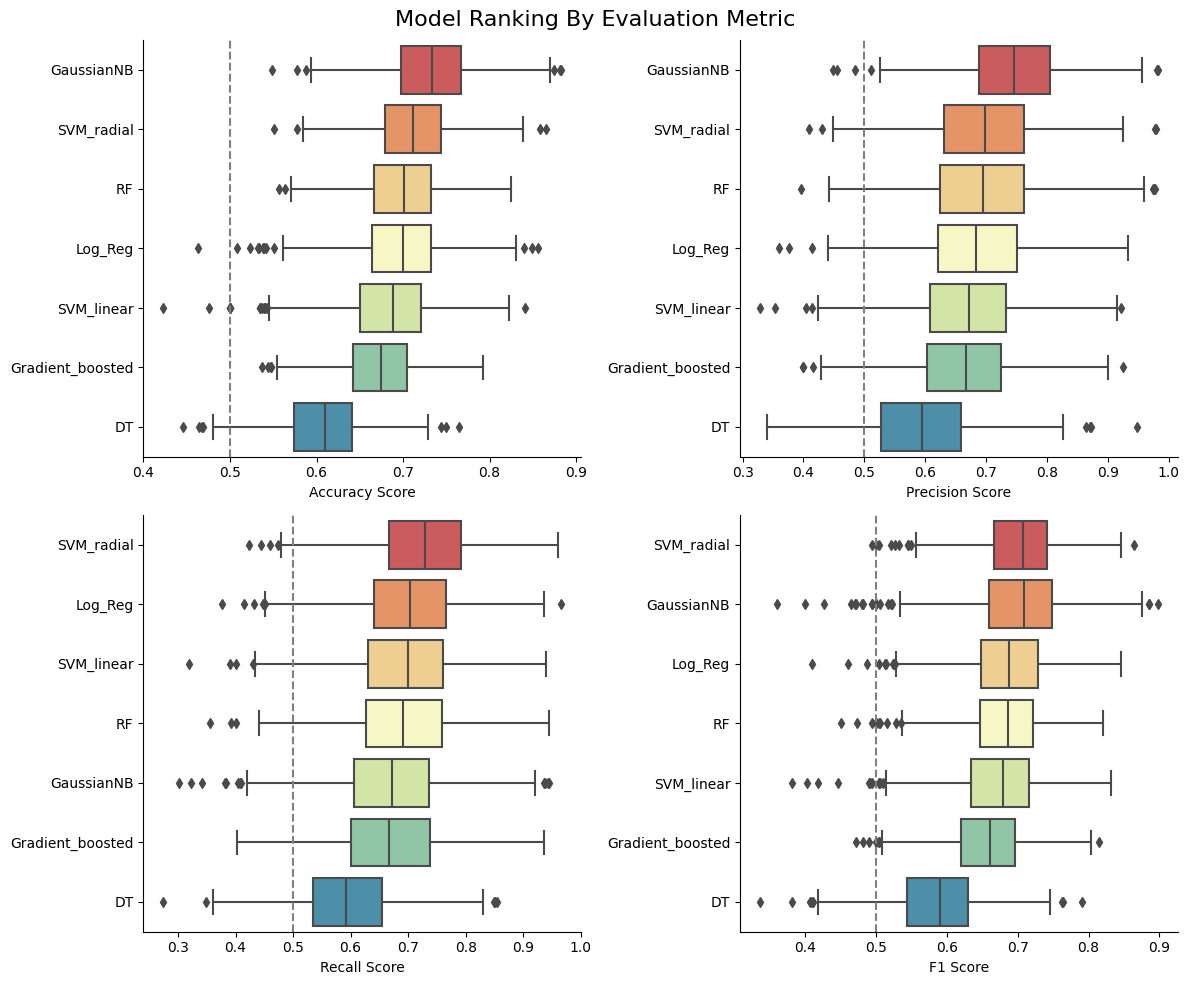

In [6]:
# List metrics
metrics = ["Accuracy", "Precision", "Recall", "F1"]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Loop through the metrics and plot on the corresponding subplot
for i, metric in enumerate(metrics):
    row = i // 2  # Determine the row of the subplot
    col = i % 2  # Determine the column of the subplot

    # Plot model scores on specific subplot
    subplot_plot_model_scores(
        model_scores_dict[metric], ml_df, metric, ax=axes[row, col]
    )

plt.suptitle("Model Ranking By Evaluation Metric", fontsize=16)

# Tighten layout
plt.tight_layout()

# Show the plot
plt.show()

## Train specific models on different samples (by donor id)

### Logistic Regression Model Evaluation and Visualization

In [7]:
# Initialize lists to store scores and coefficients
train_scores = []
test_scores = []
coefs = []

iterations = 1000
file_path = "../data/processed/boot_splits.pkl"
boot_splits = get_boot_splits(file_path, iterations, ml_df, donor_ids, samples)

# Perform the following operations for 1000 iterations
for i in range(0, iterations):
    # Random split data with constom function
    X_train, y_train, X_test, y_test = boot_splits[i]

    # Create a logistic regression classifier
    clf = LogisticRegression(random_state=42)

    # Fit the classifier on the training data
    clf.fit(X_train, y_train)

    # Store the coefficients of the trained model
    coefs.append(clf.coef_[0])

    # Evaluate the model on the training set
    preds = clf.predict(X_train)
    f1_score_train = f1_score(y_train, preds)
    train_scores.append(np.round(f1_score_train, 4))

    # Evaluate the model on the test set
    preds = clf.predict(X_test)
    f1_score_test = f1_score(y_test, preds)
    test_scores.append(np.round(f1_score_test, 4))


# Print results after 1000 iterations
print("Training Logsitic Regession on Shuffled Donor IDs...")
print(f"After {i+1} iterations:")

# Display the first 3 scores for both training and test sets
print("First 3 scores...")
print("Train Scores (F1): ", train_scores[:3])
print("Test Scores (F1): ", test_scores[:3])

# Display mean F1 scores for training and test sets
print("mean Train: ", np.round(np.mean(train_scores), 4))
print("mean Test: ", np.round(np.mean(test_scores), 4))

# Display standard deviation of F1 scores for training and test sets
print("Training std : ", np.round(np.std(train_scores), 4))
print("Testing std : ", np.round(np.std(test_scores), 4))

base_lr_scores_dict = {"train": train_scores, "test": test_scores, "coefs": coefs}

file_path = "../data/processed/base_lr_scores_dict.pkl"
# Save
with open(file_path, "wb") as file:
    pkl.dump(base_lr_scores_dict, file)

Boostrapped data loaded successfully!
Training Logsitic Regession on Shuffled Donor IDs...
After 1000 iterations:
First 3 scores...
Train Scores (F1):  [0.8099, 0.8396, 0.8312]
Test Scores (F1):  [0.7244, 0.64, 0.6723]
mean Train:  0.8163
mean Test:  0.6854
Training std :  0.0289
Testing std :  0.0599


In [8]:
# Local Plotting Function (sorted_scores)
def plot_sorted_scores(train_scores, test_scores, model_name):
    """
    Plot sorted training and testing scores for a given model.

    Parameters:
    - train_scores: List of training scores
    - test_scores: List of testing scores
    - model_name: Name of the model for the plot title
    """

    # Plot the sorted training scores
    plt.plot(
        sorted(train_scores),
        label=f"Training, Mean = {np.round(np.mean(train_scores), 2)}",
    )

    # Plot the sorted test scores
    plt.plot(
        sorted(test_scores),
        label=f"Testing Data, Mean = {np.round(np.mean(test_scores), 2)}",
    )

    # Set plot title
    plt.title(f"Sorted {model_name} Scores on Shuffled Data")

    # Set y-axis label
    plt.ylabel("Score (F1)")

    # Set x-axis label
    plt.xlabel("Iterations")

    # Remove top and right spines for aesthetics
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    # Display legend to label the lines
    plt.legend()

    # Display the plot
    plt.show()


# Local Plotting Function (coefficients/importance score)
def plot_coeffs(coefs, x_axis_lable=None, title=None):
    """
    Plot bootstrapped coefficients for a given model.

    Parameters:
    - coefs: List of bootstrapped coefficients
    - x_axis_label: Label for the x-axis
    - title: Title for the plot
    """

    # Create a DataFrame from the list of coefficients
    coefs_df = pd.DataFrame(coefs)

    # Calculate mean and standard error of the coefficients
    coefs_mean = coefs_df.T.mean(axis=1)
    coefs_sem = coefs_df.T.sem(axis=1)

    # Read gene data from CSV file
    gene_data = pd.read_csv(
        "../data/raw/gene_expression_matrix_2016-03-03/rows-genes.csv"
    )

    # Extract gene list from the original DataFrame
    gene_list = np.array(ml_df.set_index("rnaseq_profile_id").columns[:-1])

    # Create a DataFrame for gene ranking based on mean coefficients
    gene_ids_ranking = (
        pd.DataFrame.from_dict(
            {k: v for k, v in zip(gene_list, coefs_mean)},
            orient="index",
            columns=["coef"],
        )
        .rename_axis("gene_id")
        .reset_index()
        .sort_values(by="coef", ascending=False)
    )

    # Define sorting order for visualization
    sort_order = np.argsort(coefs_mean.values)
    descending_sort = sort_order[::-1]

    # Display the ranked gene coefficients
    gene_ids_ranking

    # Add standard error information to the gene ranking DataFrame
    gene_ids_ranking["sem"] = coefs_sem

    # Merge gene ranking data with additional gene information
    gene_ids_ranking = gene_ids_ranking.merge(gene_data, on="gene_id")

    # Create a horizontal boxplot for visualizing coefficients
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        coefs_df[descending_sort],
        orient="h",
    )
    y_labels = gene_ids_ranking["gene_symbol"]
    plt.yticks(range(len(y_labels)), y_labels)
    plt.title(title)
    plt.xlabel(x_axis_lable)
    plt.ylabel("Gene Symbol")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    # Add a vertical dashed line at zero for reference
    plt.axvline(0, color="red", linestyle="--")

    # Adjust layout for better presentation
    plt.tight_layout()

    # Display the plot
    plt.show()

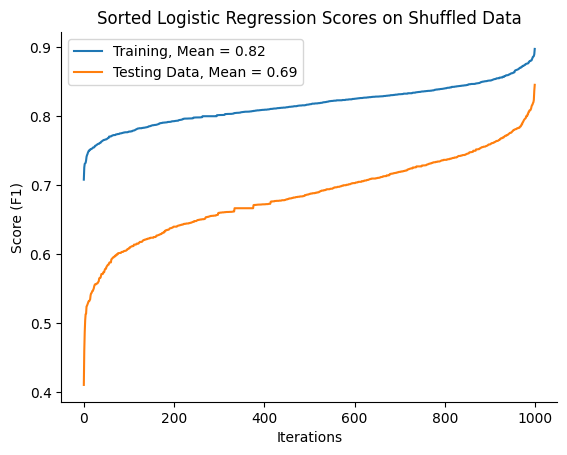

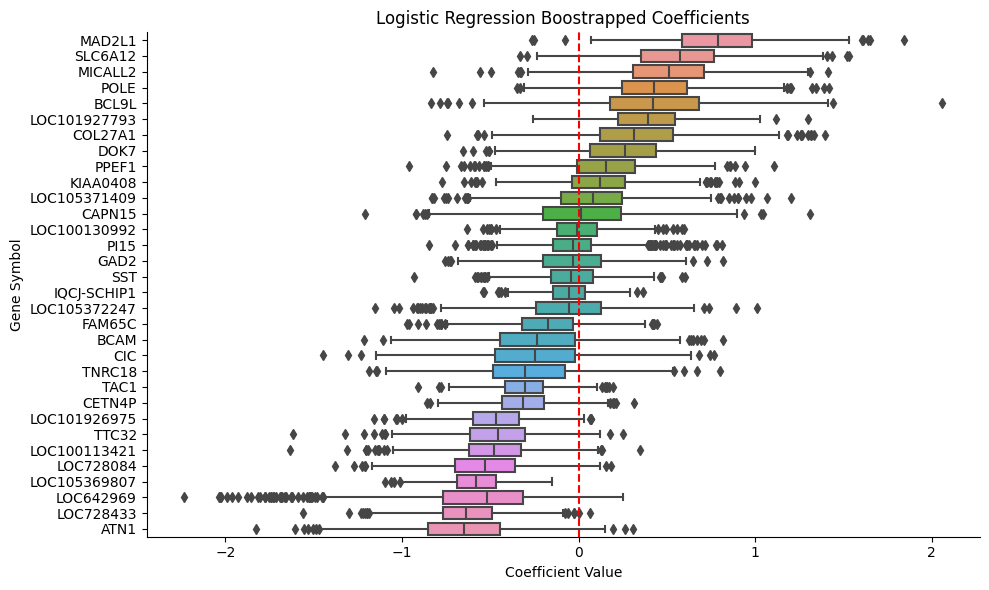

In [9]:
# Plots
plot_sorted_scores(train_scores, test_scores, "Logistic Regression")
plot_coeffs(
    coefs,
    x_axis_lable="Coefficient Value",
    title="Logistic Regression Boostrapped Coefficients",
)

### Gaussian NB Model Evaluation and Visualization

In [10]:
def importance_boot(
    model,
    boot_splits,
    verbose=True,
    selected_feature_indices=None,
):
    """
    Evaluate the importance of features using bootstrapped permutation importances.

    Parameters:
    - model: A machine learning model instance (e.g., classifier/regressor)
    - verbose: If true, returns statistics for assessment
    - featues_subset: index of subset of features to use

    Returns:
    - None: Prints and displays the results of feature importance evaluation.
    """

    # Initialize empty lists to store scores and importances
    train_scores = []
    test_scores = []
    coefs = []

    # Perform 1000 iterations
    for i in range(0, 1000):
        # Split the data into training and testing sets using a custom function
        if selected_feature_indices is not None:
            X_train, y_train, X_test, y_test = boot_splits[i]
            X_train = X_train[:, selected_feature_indices]
            X_test = X_test[:, selected_feature_indices]

        else:
            X_train, y_train, X_test, y_test = boot_splits[i]
        # Instantiate a Gaussian Naive Bayes classifier
        clf = model

        # Fit the classifier on the training data
        clf.fit(X_train, y_train)

        # Calculate permutation importances and store the mean importances
        imps = permutation_importance(
            clf, X_test, y_test, random_state=42, scoring="f1"
        )
        coefs.append(imps.importances_mean)

        # Predictions on the training set and calculate F1 score
        preds = clf.predict(X_train)
        f1_score_train = f1_score(y_train, preds)
        train_scores.append(np.round(f1_score_train, 4))

        # Predictions on the test set and calculate F1 score
        preds = clf.predict(X_test)
        f1_score_test = f1_score(y_test, preds)
        test_scores.append(np.round(f1_score_test, 4))

    if verbose == True:
        # Display the results after 1000 iterations
        print("Training on Shuffled Donor IDs...")
        print(f"After {i+1} iterations:")

        # Display the first 3 scores
        print("First 3 scores...")
        print("Train Scores (F1): ", train_scores[:3])
        print("Test Scores (F1): ", test_scores[:3])

        # Display the mean and standard deviation of training and testing scores
        print("mean Train: ", np.round(np.mean(train_scores), 4))
        print("mean Test: ", np.round(np.mean(test_scores), 4))
        print("Training std : ", np.round(np.std(train_scores), 4))
        print("Testing std : ", np.round(np.std(test_scores), 4))

    return train_scores, test_scores, coefs

In [11]:
file_path = "../data/processed/base_NB_scores_dict.pkl"
if os.path.exists(file_path):
    with open(file_path, "rb") as file:
        base_NB_scores_dict = pkl.load(file)

else:
    model = GaussianNB()
    train_scores, test_scores, importances = importance_boot(
        model, boot_splits, verbose=True
    )

    base_NB_scores_dict = {
        "train": train_scores,
        "test": test_scores,
        "coefs": importances,
    }
    # Save
    with open(file_path, "wb") as file:
        pkl.dump(base_lr_scores_dict, file)

train_scores, test_scores, importances = (
    base_NB_scores_dict["train"],
    base_NB_scores_dict["test"],
    base_NB_scores_dict["coefs"],
)

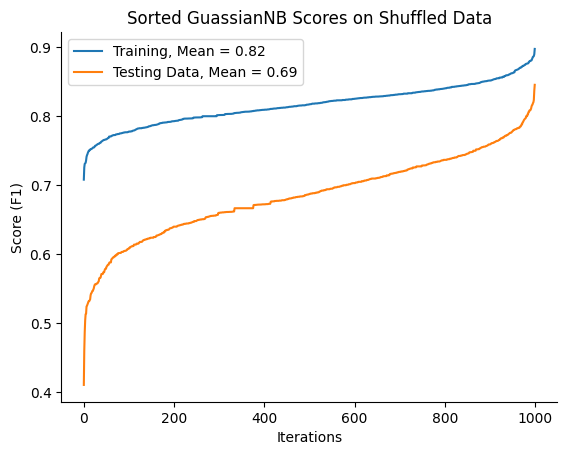

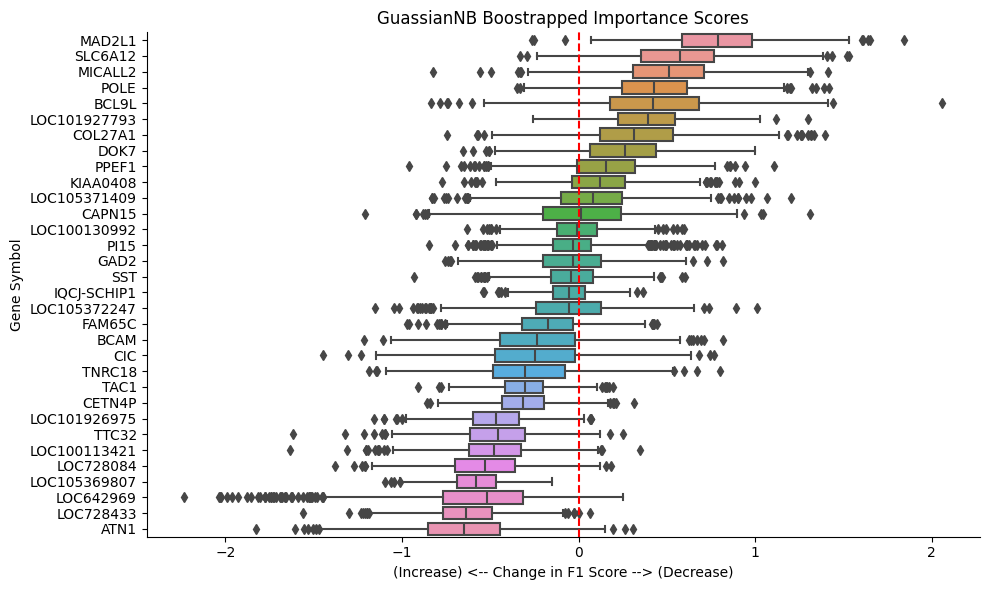

In [12]:
# Plots scores
plot_sorted_scores(train_scores, test_scores, "GuassianNB")

# Plot Importance Scores
plot_coeffs(
    importances,
    x_axis_lable="(Increase) <-- Change in F1 Score --> (Decrease)",
    title="GuassianNB Boostrapped Importance Scores",
)

### SVM Model Evaluation and Visualization

In [13]:
file_path = "../data/processed/base_SVM_scores_dict.pkl"
if os.path.exists(file_path):
    with open(file_path, "rb") as file:
        base_SVM_scores_dict = pkl.load(file)

else:
    model = SVC(kernel="rbf", random_state=42)
    train_scores, test_scores, importances = importance_boot(
        model, boot_splits, verbose=True
    )

    base_SVM_scores_dict = {
        "train": train_scores,
        "test": test_scores,
        "coefs": importances,
    }
    # Save
    with open(file_path, "wb") as file:
        pkl.dump(base_SVM_scores_dict, file)

train_scores, test_scores, importances = (
    base_SVM_scores_dict["train"],
    base_SVM_scores_dict["test"],
    base_SVM_scores_dict["coefs"],
)

Training on Shuffled Donor IDs...
After 1000 iterations:
First 3 scores...
Train Scores (F1):  [0.8306, 0.8629, 0.8305]
Test Scores (F1):  [0.7402, 0.6535, 0.6833]
mean Train:  0.8477
mean Test:  0.7034
Training std :  0.0223
Testing std :  0.0556


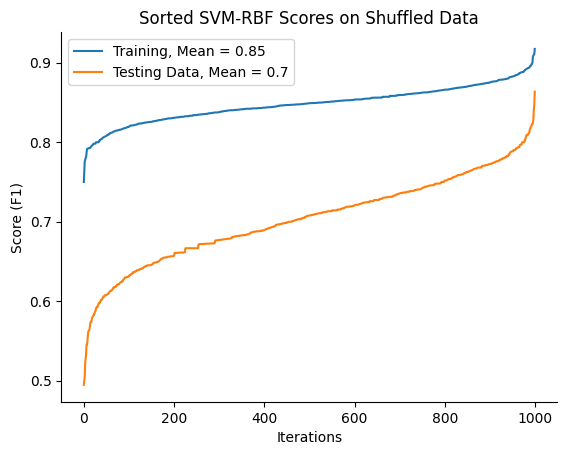

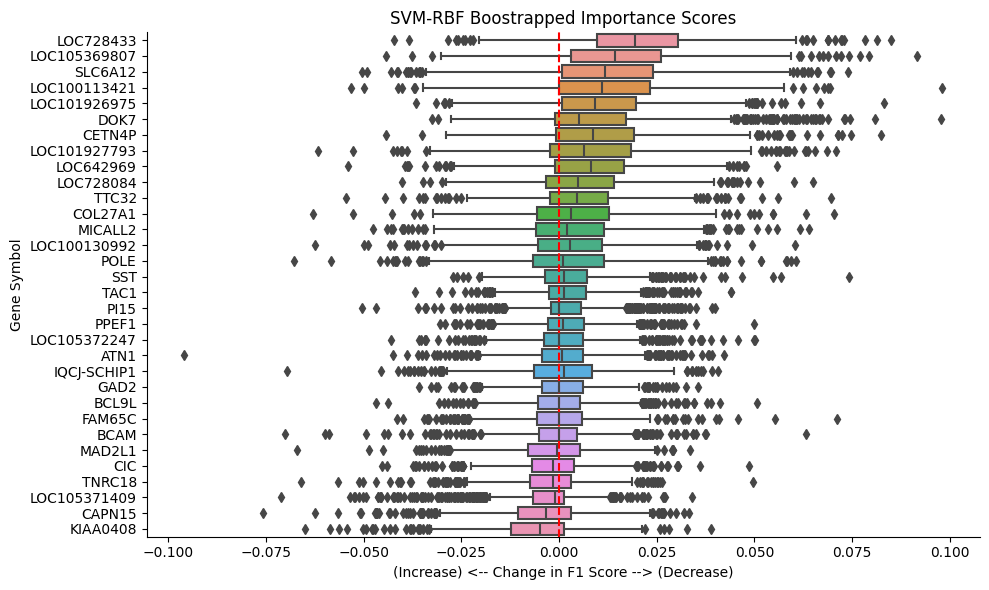

In [14]:
# Plots scores
plot_sorted_scores(train_scores, test_scores, "SVM-RBF")

# Plot Importance Scores
plot_coeffs(
    importances,
    x_axis_lable="(Increase) <-- Change in F1 Score --> (Decrease)",
    title="SVM-RBF Boostrapped Importance Scores",
)

Training on Shuffled Donor IDs...
After 1000 iterations:
First 3 scores...
Train Scores (F1):  [0.8382, 0.8532, 0.8158]
Test Scores (F1):  [0.7597, 0.6667, 0.6379]
mean Train:  0.8241
mean Test:  0.6736
Training std :  0.0288
Testing std :  0.0614


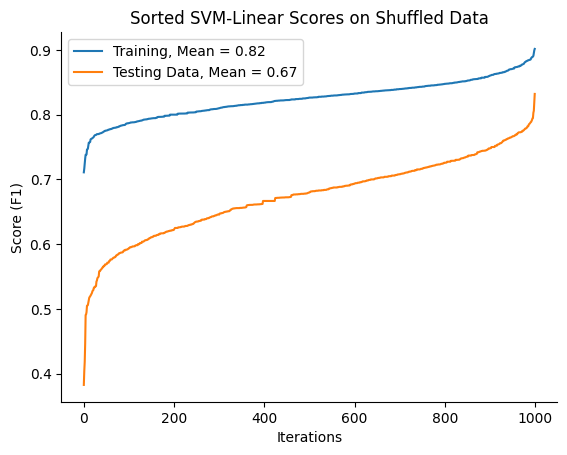

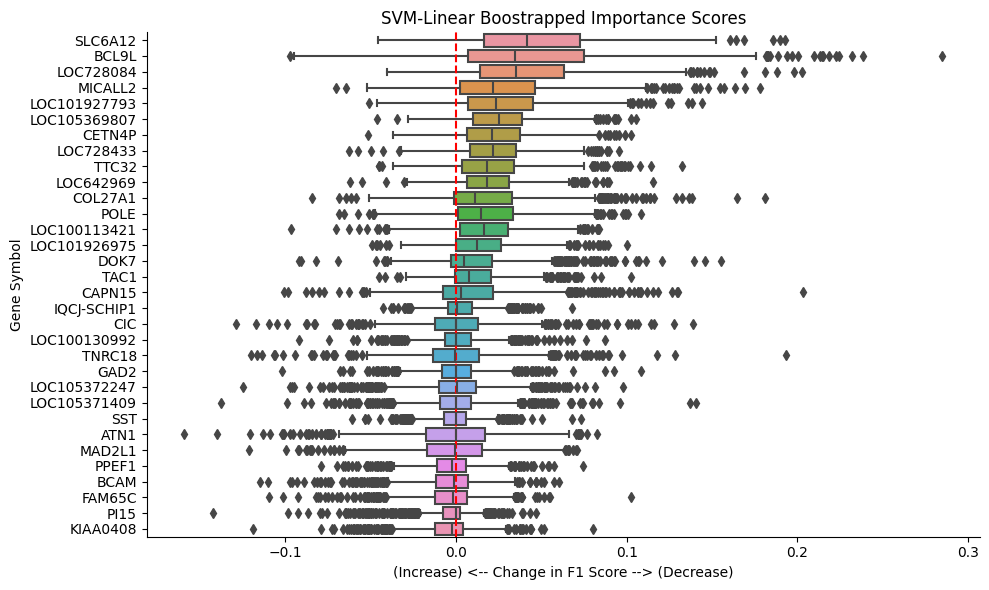

In [15]:
file_path = "../data/processed/base_SVM_linear_scores_dict.pkl"
if os.path.exists(file_path):
    with open(file_path, "rb") as file:
        base_SVM_linear_scores_dict = pkl.load(file)

else:
    model = SVC(kernel="linear", random_state=42)
    train_scores, test_scores, importances = importance_boot(
        model, boot_splits, verbose=True
    )

    base_SVM_linear_scores_dict = {
        "train": train_scores,
        "test": test_scores,
        "coefs": importances,
    }
    # Save
    with open(file_path, "wb") as file:
        pkl.dump(base_SVM_scores_dict, file)

train_scores, test_scores, importances = (
    base_SVM_linear_scores_dict["train"],
    base_SVM_linear_scores_dict["test"],
    base_SVM_linear_scores_dict["coefs"],
)

# Plots scores
plot_sorted_scores(train_scores, test_scores, "SVM-Linear")

# Plot Importance Scores
plot_coeffs(
    importances,
    x_axis_lable="(Increase) <-- Change in F1 Score --> (Decrease)",
    title="SVM-Linear Boostrapped Importance Scores",
)

### Random Forest Model Evaluation and Visualization

In [16]:
file_path = "../data/processed/base_Forest_scores_dict.pkl"
if os.path.exists(file_path):
    with open(file_path, "rb") as file:
        base_Forest_scores_dict = pkl.load(file)

else:
    model = RandomForestClassifier(random_state=42)
    train_scores, test_scores, importances = importance_boot(
        model, boot_splits, verbose=True
    )

    base_Forest_scores_dict = {
        "train": train_scores,
        "test": test_scores,
        "coefs": importances,
    }
    # Save
    with open(file_path, "wb") as file:
        pkl.dump(base_Forest_scores_dict, file)

train_scores, test_scores, importances = (
    base_Forest_scores_dict["train"],
    base_Forest_scores_dict["test"],
    base_Forest_scores_dict["coefs"],
)

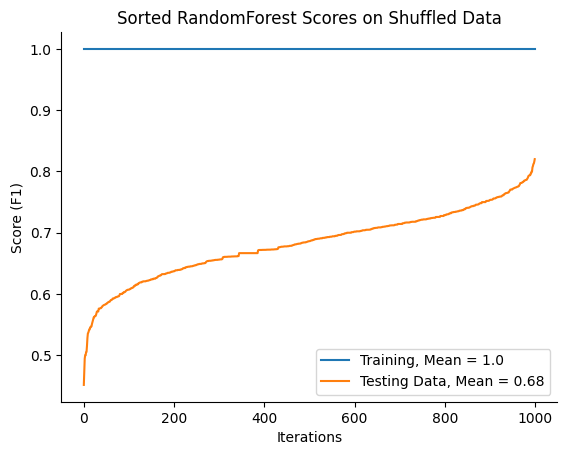

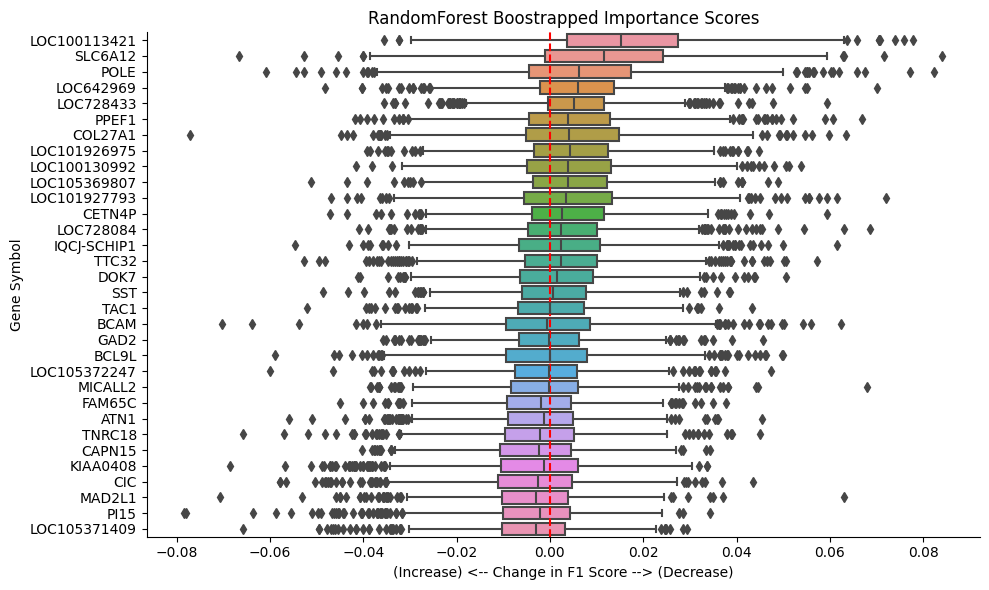

In [17]:
# Plots scores
plot_sorted_scores(train_scores, test_scores, "RandomForest")

# Plot Importance Scores
plot_coeffs(
    importances,
    x_axis_lable="(Increase) <-- Change in F1 Score --> (Decrease)",
    title="RandomForest Boostrapped Importance Scores",
)

### Gradient Boosted Model Evaluation and Visualization

In [18]:
file_path = "../data/processed/base_Boosting_scores_dict.pkl"
if os.path.exists(file_path):
    with open(file_path, "rb") as file:
        base_Boosting_scores_dict = pkl.load(file)

else:
    model = GradientBoostingClassifier(random_state=42)
    train_scores, test_scores, importances = importance_boot(
        model, boot_splits, verbose=True
    )

    base_Boosting_scores_dict = {
        "train": train_scores,
        "test": test_scores,
        "coefs": importances,
    }
    # Save
    with open(file_path, "wb") as file:
        pkl.dump(base_Boosting_scores_dict, file)

train_scores, test_scores, importances = (
    base_Boosting_scores_dict["train"],
    base_Boosting_scores_dict["test"],
    base_Boosting_scores_dict["coefs"],
)

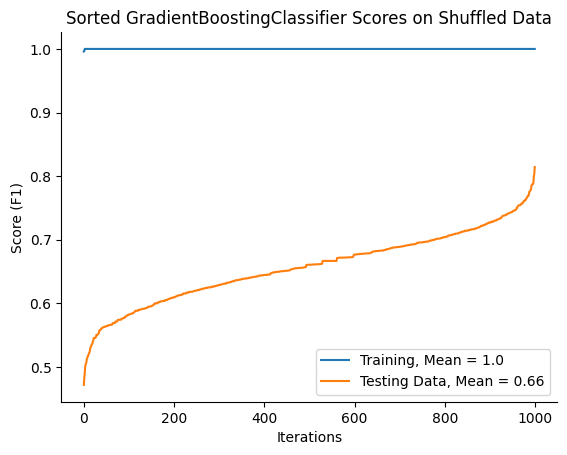

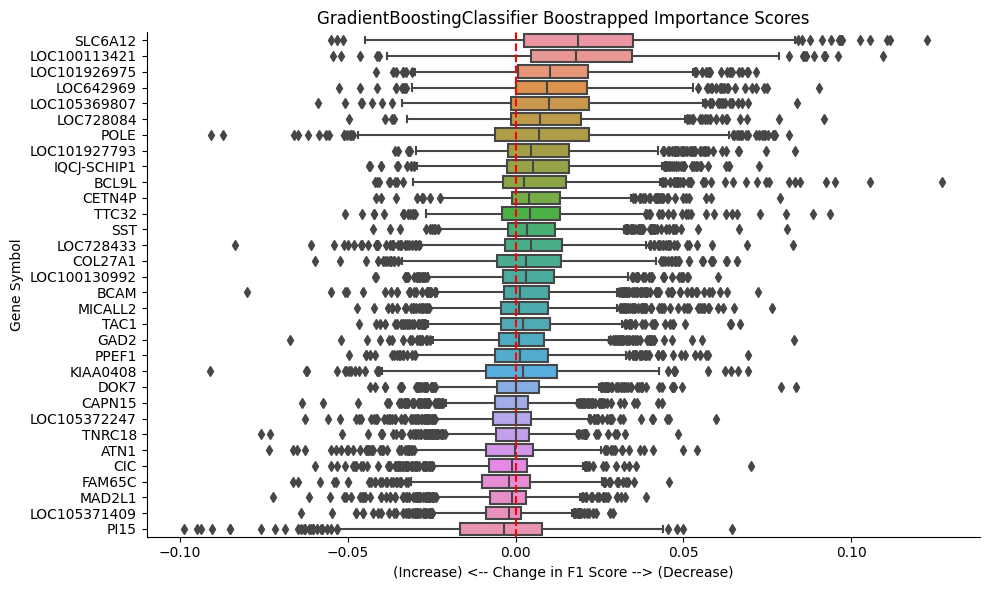

In [19]:
# Plots scores
plot_sorted_scores(train_scores, test_scores, "GradientBoostingClassifier")

# Plot Importance Scores
plot_coeffs(
    importances,
    x_axis_lable="(Increase) <-- Change in F1 Score --> (Decrease)",
    title="GradientBoostingClassifier Boostrapped Importance Scores",
)

## Evaluating Multicollinear Features

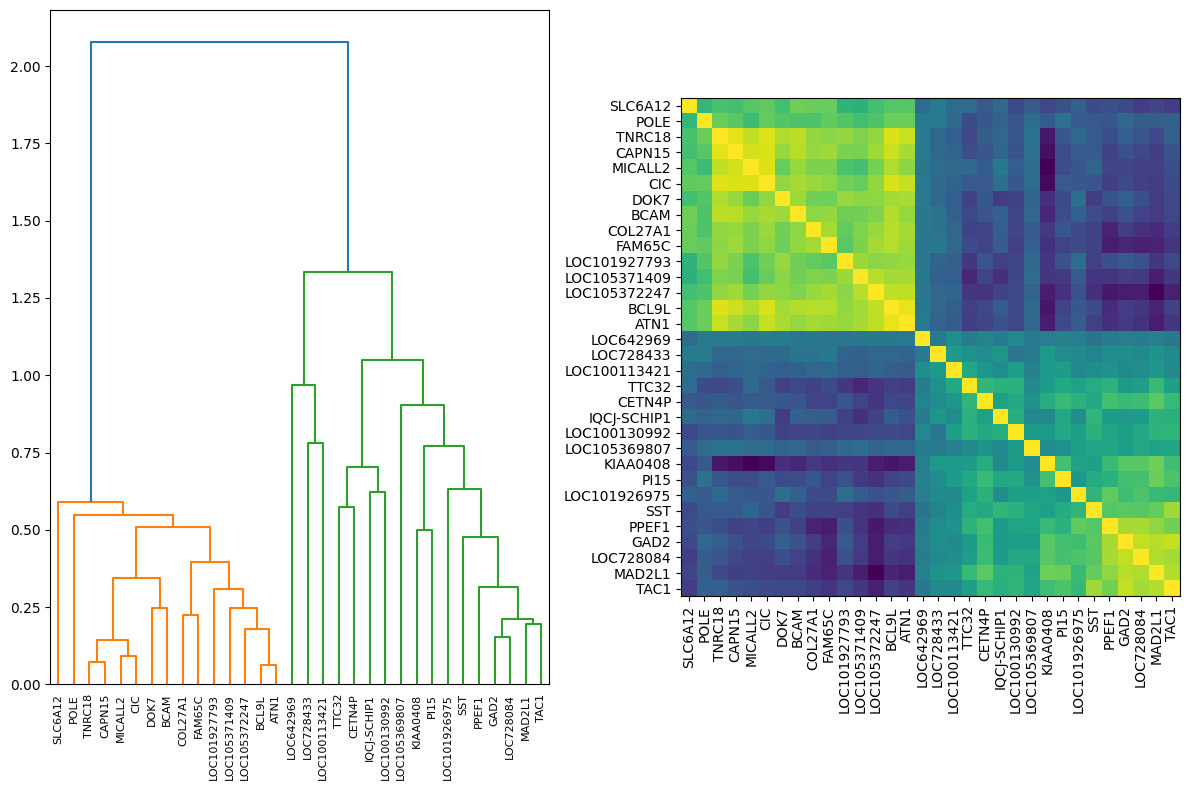

In [20]:
# Inspired by sklearn docs

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

# Read gene data from CSV file
gene_data = pd.read_csv("../data/raw/gene_expression_matrix_2016-03-03/rows-genes.csv")

# Extract gene list from the original DataFrame
gene_list = np.array(ml_df.set_index("rnaseq_profile_id").columns[:-1])

X = ml_df.drop(columns=["rnaseq_profile_id", "Condition"])
X.columns = gene_data[gene_data["gene_id"].isin(X.columns)]["gene_symbol"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()
# plt.suptitle('Collinearity Analysis', fontsize=16)

In [21]:
from collections import defaultdict

# Extract relevant features from the DataFrame
X = ml_df.drop(columns=["rnaseq_profile_id", "Condition"])

# Calculate Spearman correlation matrix
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
# Set diagonal elements to 1
np.fill_diagonal(corr, 1)

# Convert the correlation matrix to a distance matrix
# (This step is necessary for hierarchical clustering)
distance_matrix = 1 - np.abs(corr)

# Perform hierarchical clustering using Ward's linkage
dist_linkage = hierarchy.ward(squareform(distance_matrix))

# Apply hierarchical clustering and obtain cluster IDs
cluster_ids = hierarchy.fcluster(dist_linkage, 0.5, criterion="distance")

# Create a dictionary to map cluster IDs to feature indices
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

# Extract selected features based on the clustering
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X.columns[selected_features]

# Extract column indices of the selected features
selected_feature_indices = [
    X.columns.get_loc(feature) for feature in selected_features_names
]

In [22]:
# Initialize lists to store scores and coefficients
train_scores = []
test_scores = []
coefs = []

# Perform the following operations for 1000 iterations
for i in range(0, 1000):
    # Subset features

    # Random split data with custom function
    X_train, y_train, X_test, y_test = boot_splits[i]
    X_train = X_train[:, selected_feature_indices]
    X_test = X_test[:, selected_feature_indices]

    # Create a logistic regression classifier
    clf = LogisticRegression(random_state=42)

    # Fit the classifier on the training data
    clf.fit(X_train, y_train)

    # Store the coefficients of the trained model
    coefs.append(clf.coef_[0])

    # Evaluate the model on the training set
    preds = clf.predict(X_train)
    f1_score_train = f1_score(y_train, preds)
    train_scores.append(np.round(f1_score_train, 4))

    # Evaluate the model on the test set
    preds = clf.predict(X_test)
    f1_score_test = f1_score(y_test, preds)
    test_scores.append(np.round(f1_score_test, 4))


# Print results after 1000 iterations
print("Training Logsitic Regession on Shuffled Donor IDs...")
print(f"After {i+1} iterations:")

# Display the first 3 scores for both training and test sets
print("First 3 scores...")
print("Train Scores (F1): ", train_scores[:3])
print("Test Scores (F1): ", test_scores[:3])

# Display mean F1 scores for training and test sets
print("mean Train: ", np.round(np.mean(train_scores), 4))
print("mean Test: ", np.round(np.mean(test_scores), 4))

# Display standard deviation of F1 scores for training and test sets
print("Training std : ", np.round(np.std(train_scores), 4))
print("Testing std : ", np.round(np.std(test_scores), 4))

Training Logsitic Regession on Shuffled Donor IDs...
After 1000 iterations:
First 3 scores...
Train Scores (F1):  [0.7903, 0.8163, 0.8085]
Test Scores (F1):  [0.7302, 0.6733, 0.7188]
mean Train:  0.7859
mean Test:  0.7113
Training std :  0.0343
Testing std :  0.0569


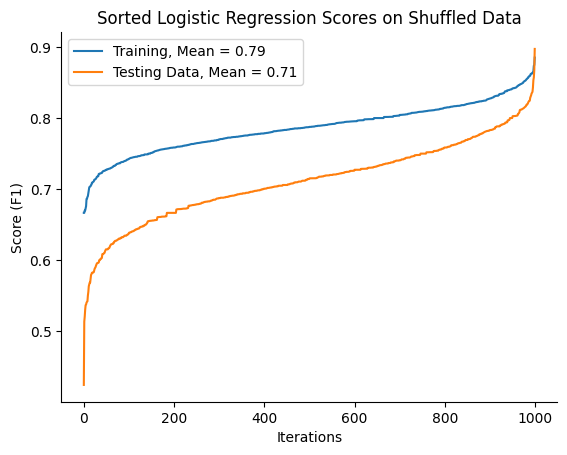

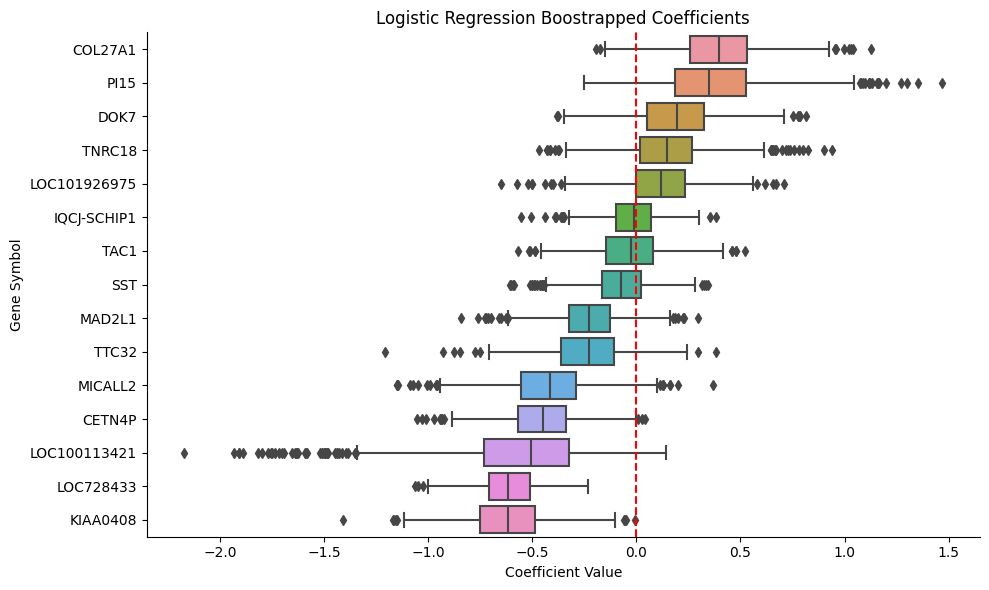

In [23]:
# Plots
plot_sorted_scores(train_scores, test_scores, "Logistic Regression")
plot_coeffs(
    coefs,
    x_axis_lable="Coefficient Value",
    title="Logistic Regression Boostrapped Coefficients",
)

In [24]:
model = GaussianNB()
train_scores, test_scores, importances = importance_boot(
    model, boot_splits, verbose=True, selected_feature_indices=selected_feature_indices
)

Training on Shuffled Donor IDs...
After 1000 iterations:
First 3 scores...
Train Scores (F1):  [0.7656, 0.7973, 0.7649]
Test Scores (F1):  [0.7704, 0.6452, 0.7692]
mean Train:  0.7735
mean Test:  0.7486
Training std :  0.0287
Testing std :  0.0588


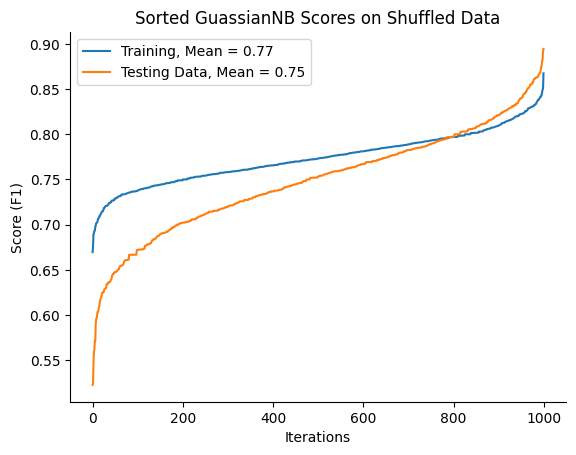

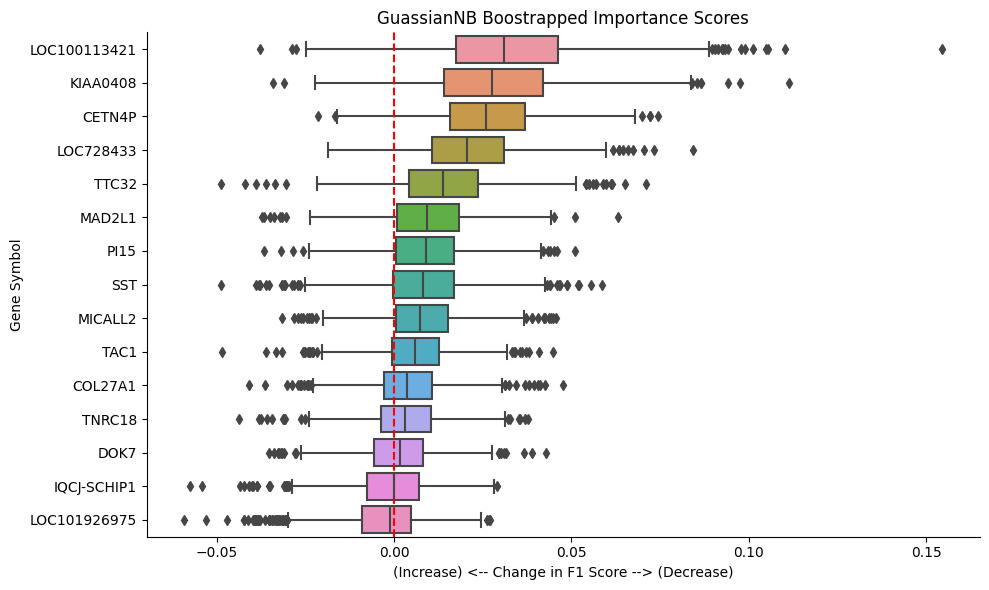

In [25]:
# Plots scores
plot_sorted_scores(train_scores, test_scores, "GuassianNB")

# Plot Importance Scores
plot_coeffs(
    importances,
    x_axis_lable="(Increase) <-- Change in F1 Score --> (Decrease)",
    title="GuassianNB Boostrapped Importance Scores",
)

Training on Shuffled Donor IDs...
After 1000 iterations:
First 3 scores...
Train Scores (F1):  [0.8458, 0.8687, 0.85]
Test Scores (F1):  [0.7846, 0.66, 0.7176]
mean Train:  0.847
mean Test:  0.722
Training std :  0.0246
Testing std :  0.0524


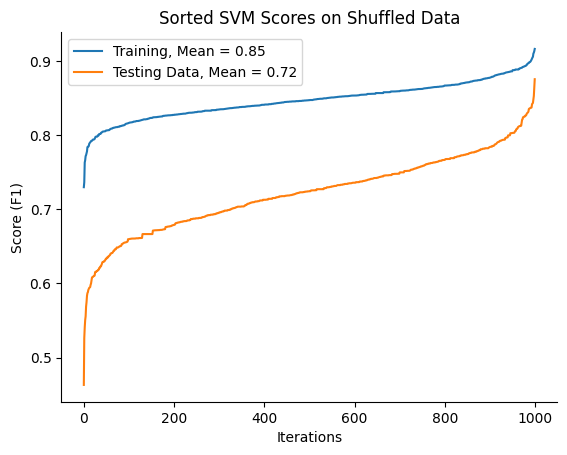

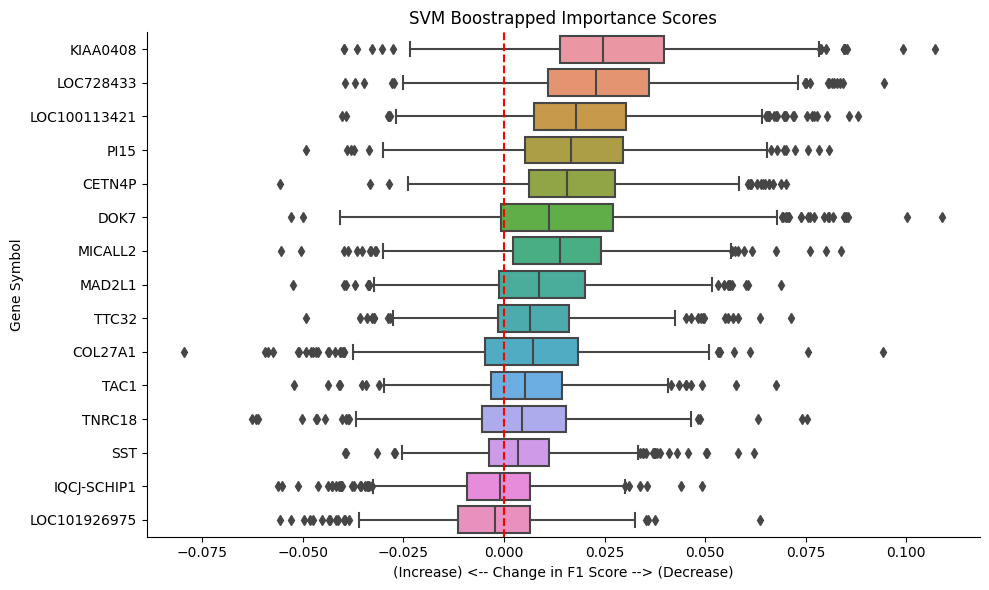

In [26]:
model = SVC(kernel="rbf", random_state=42)
train_scores, test_scores, importances = importance_boot(
    model, boot_splits, verbose=True, selected_feature_indices=selected_feature_indices
)

# Plots scores
plot_sorted_scores(train_scores, test_scores, "SVM")

# Plot Importance Scores
plot_coeffs(
    importances,
    x_axis_lable="(Increase) <-- Change in F1 Score --> (Decrease)",
    title="SVM Boostrapped Importance Scores",
)

## Save features

In [27]:
file_path = "../data/processed/selected_feature_indices.pkl"
with open(file_path, "wb") as file:
    pkl.dump(selected_feature_indices, file)